In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# import rapids_singlecell as rsc
import scanpy as sc
from scipy.stats import f_oneway, kruskal, mannwhitneyu, false_discovery_control
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/')
from clinical import load_clinical
from data_processing import *
from hpc_annotations import *
from spatial import *

# Kernel: scpy

In [2]:
adata_stroma = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/04_adata_stroma_clustered_kmeans_9_withtext.h5ad')
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/03_LUAD_markers_clustered_2p0_4slides_with_phenotypes.h5ad')

In [ ]:
adata.obs['core_ID'].nunique()

436

In [4]:
adata.obs

,core_ID,CellX,CellY,TMA,samples,leiden_0.5,leiden_0.6,leiden_0.8,leiden_1.0,leiden_1.5,leiden_2.0,cell_lineage,immune_lineage
cell_0,12-15-J,2396.8,6263.1,12,ACA_0662,21,26,25,31,45,56,stroma,NaN
cell_1,12-15-J,2420.0,6264.4,12,ACA_0662,5,30,18,38,5,5,tumour,NaN
cell_2,12-15-J,2428.9,6265.5,12,ACA_0662,5,30,18,38,65,5,tumour,NaN
cell_3,12-15-J,2409.4,6267.8,12,ACA_0662,5,30,18,38,5,5,tumour,NaN
cell_4,12-15-J,2474.5,6266.5,12,ACA_0662,9,13,28,33,51,62,unclassifiable,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_2670918,22-15-J,17607.6,20332.7,22,ACA_1069,26,13,36,45,58,75,immune,CD45+ CD4+
cell_2670919,22-15-J,17733.6,20460.9,22,ACA_1069,26,15,9,13,21,27,immune,CD45+ CD20+
cell_2670920,22-15-J,17500.8,20961.7,22,ACA_1069,26,15,33,45,10,12,stroma,NaN
cell_2670921,22-15-J,17685.7,20402.6,22,ACA_1069,26,20,36,45,21,27,immune,CD45+ CD20+


In [5]:
pure_clusters_frame = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/pure_cores_codex_by_supercluster_bioclavis_gs.csv', index_col=0)
pure_clusters_frame

,core_ID,supercluster,cluster
0,12-02-A,cold_discohesive,HPC 27
1,12-02-B,hot_cohesive,HPC 0
2,12-02-C,hot_cohesive,HPC 67
3,12-02-D,hot_discohesive,HPC 10
4,12-02-F,cold_cohesive,NaN
...,...,...,...
300,22-14-G,cold_cohesive,HPC 68
301,22-14-H,hot_discohesive,HPC 28
302,22-15-A,hot_cohesive,HPC 50
303,22-15-I,hot_cohesive,HPC 50


In [ ]:
# pure_clusters_frame.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/codex_pure_clusters_frame.csv')

In [ ]:
# Cosmetics
pure_clusters_frame = pure_clusters_frame.replace({'cold_cohesive':'Cold, cohesive', 'cold_discohesive':'Cold, discohesive', 'hot_cohesive':'Hot, cohesive', 'hot_discohesive':'Hot, discohesive'})
pure_clusters_frame

,core_ID,supercluster,cluster
0,12-02-A,"Cold, discohesive",HPC 27
1,12-02-B,"Hot, cohesive",HPC 0
2,12-02-C,"Hot, cohesive",HPC 67
3,12-02-D,"Hot, discohesive",HPC 10
4,12-02-F,"Cold, cohesive",NaN
...,...,...,...
300,22-14-G,"Cold, cohesive",HPC 68
301,22-14-H,"Hot, discohesive",HPC 28
302,22-15-A,"Hot, cohesive",HPC 50
303,22-15-I,"Hot, cohesive",HPC 50


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

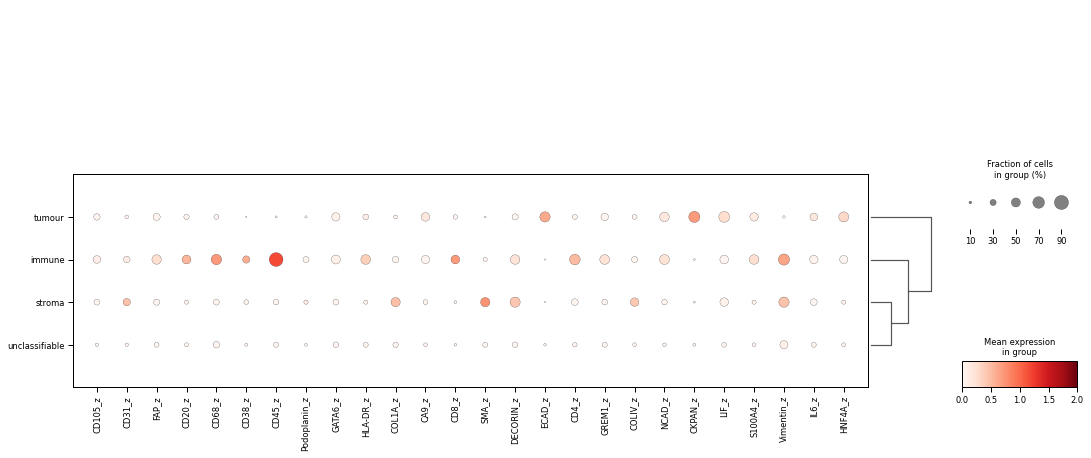

In [8]:
sns.set_context("paper", font_scale=2.5)

# Clustering in previous notebook '0.1_fibroblast_reclustering'

sc.tl.dendrogram(adata=adata, groupby='cell_lineage')
fig, ax = plt.subplots(figsize=(18,7))
sc.pl.dotplot(adata, var_names=adata.var_names, groupby='cell_lineage', dendrogram=True, ax=ax, vmin=0, vmax=2, show=False)


In [9]:
adata.obs

,core_ID,CellX,CellY,TMA,samples,leiden_0.5,leiden_0.6,leiden_0.8,leiden_1.0,leiden_1.5,leiden_2.0,cell_lineage,immune_lineage
cell_0,12-15-J,2396.8,6263.1,12,ACA_0662,21,26,25,31,45,56,stroma,NaN
cell_1,12-15-J,2420.0,6264.4,12,ACA_0662,5,30,18,38,5,5,tumour,NaN
cell_2,12-15-J,2428.9,6265.5,12,ACA_0662,5,30,18,38,65,5,tumour,NaN
cell_3,12-15-J,2409.4,6267.8,12,ACA_0662,5,30,18,38,5,5,tumour,NaN
cell_4,12-15-J,2474.5,6266.5,12,ACA_0662,9,13,28,33,51,62,unclassifiable,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_2670918,22-15-J,17607.6,20332.7,22,ACA_1069,26,13,36,45,58,75,immune,CD45+ CD4+
cell_2670919,22-15-J,17733.6,20460.9,22,ACA_1069,26,15,9,13,21,27,immune,CD45+ CD20+
cell_2670920,22-15-J,17500.8,20961.7,22,ACA_1069,26,15,33,45,10,12,stroma,NaN
cell_2670921,22-15-J,17685.7,20402.6,22,ACA_1069,26,20,36,45,21,27,immune,CD45+ CD20+


### Introduce phenotypes

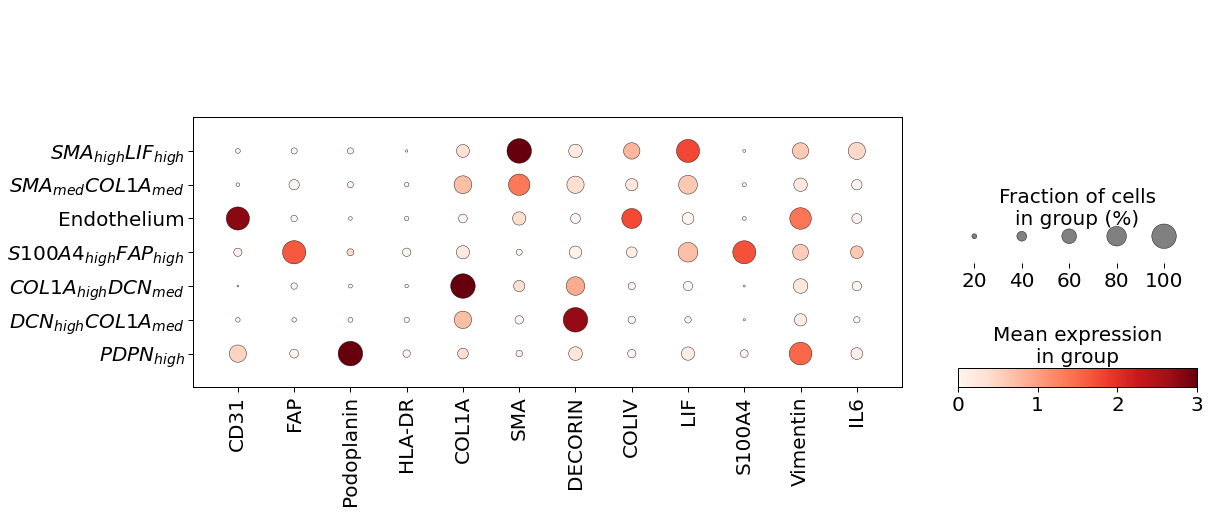

In [11]:
sns.set_context("paper", font_scale=2.5)

# Clustering in previous notebook '0.1_fibroblast_reclustering'
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

sc.tl.dendrogram(adata=adata_stroma, groupby='text_phenotype')
fig, ax = plt.subplots(figsize=(18,7))
dp = sc.pl.dotplot(adata_stroma, var_names=adata_stroma.var_names, groupby='text_phenotype', dendrogram=False, ax=ax, vmin=0, vmax=3, dot_min=0., dot_max=1, show=False, cmap='Reds', return_fig=True)
dp.style(largest_dot=600, cmap='Reds', dot_edge_lw=0.4, size_exponent=2)
# plt.show()
dp.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/phenotypes/fibroblast_phenotypes_dotplot_no_dendr.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# dp.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/phenotypes/fibroblast_phenotypes_dotplot_no_dendr.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

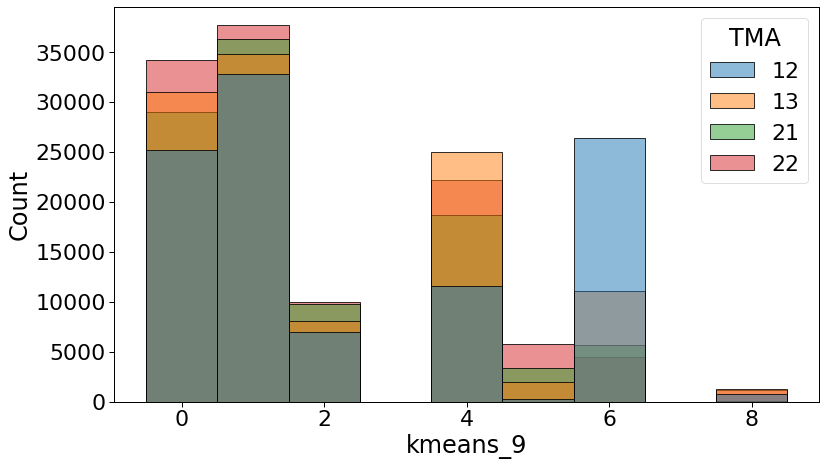

In [10]:
# CLuster frequency on TMAs -- are some TMA specific? Not really, but some predominance. 
# 3 is unclassified - filtered in this adata
# 7 was merged with 0, near identical expression profiles

fig, ax = plt.subplots(figsize=(12,7))

adata_stroma.obs['kmeans_9'] = adata_stroma.obs['kmeans_9'].astype('category')

sns.histplot(data=adata_stroma.obs, x=f'kmeans_9', hue='TMA', ax=ax)

plt.tight_layout()
plt.show()

In [11]:
# Core areas needed for dentities

area12 = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/QuPath/Codex_fibroblasts_TMA_12_13/core_area_measurements_12.csv')
area13 = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/QuPath/Codex_fibroblasts_TMA_12_13/core_area_measurements_13.csv')
area21 = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/QuPath/Codex_GS/core_area_measurements_21.csv')
area22 = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/QuPath/Codex_GS/core_area_measurements_22.csv')

core_areas = pd.concat([area12, area13, area21, area22])

core_areas = core_areas.replace({'Region*':'Tumor'})
core_areas = core_areas[core_areas['Classification'] == 'Tumor']

def extract_tma_number(name):
    if name.split('_')[0] == 'LUNG':
        x = name.split('_')[3]
    else:
        x = name.split('_')[2]
    return x

def fixed_char_width(name):
    tma_number = name.split('-')[0]
    row_number = name.split('-')[1]
    col_number = name.split('-')[2]
    if len(row_number) < 2:
        new_row_number = '0' + row_number
        new_name = tma_number + '-' + new_row_number + '-' + col_number
        return new_name
    else:
        return name

core_areas['TMA'] = core_areas['Image'].apply(lambda x: extract_tma_number(x))
core_areas['core_ID'] = core_areas['TMA'] + '-' + core_areas['TMA core']
core_areas['core_ID'] = core_areas['core_ID'].apply(lambda x: fixed_char_width(x))
core_areas = core_areas.rename(columns={'Area µm^2':'area_mcm2'})
core_areas['area_mm2'] = core_areas['area_mcm2'] / (1000 * 1000)

core_areas = core_areas[['TMA', 'core_ID', 'area_mm2']]
core_areas

,TMA,core_ID,area_mm2
0,12,12-16-J,1.112384
3,12,12-16-I,0.401053
5,12,12-16-H,0.000066
7,12,12-16-G,0.314441
9,12,12-16-F,0.261576
...,...,...,...
124,22,22-16-E,0.125866
125,22,22-16-F,0.125106
126,22,22-16-G,0.005694
127,22,22-16-I,0.474768


In [12]:
pure_clusters_frame['supercluster'].value_counts()

Cold, cohesive       86
Hot, discohesive     77
Hot, cohesive        60
Cold, discohesive    38
Name: supercluster, dtype: int64

In [13]:
cluster_pure_cores_areas = pure_clusters_frame.merge(core_areas[['core_ID', 'area_mm2']], on='core_ID')

core_cell_counts = pd.DataFrame()

for i, core in enumerate(cluster_pure_cores_areas['core_ID'].unique()):
    cell_types, counts = np.unique(adata_stroma.obs[adata_stroma.obs['core_ID'] == core]['kmeans_9'].values, return_counts=True)
    # cell_types, counts = np.unique(adata_stroma.obs[adata_stroma.obs['core_ID'] == core]['stroma_leiden_0.1'].values, return_counts=True)
    core_cell_counts.loc[i, 'core_ID'] = core
    for j, _ in enumerate(cell_types):
        core_cell_counts.loc[i, cell_types[j]] = counts[j]

core_cell_counts = core_cell_counts.fillna(0)
core_cell_counts = core_cell_counts.drop_duplicates()
core_cell_counts.columns = ['core_ID']+['kmeans_' + str(c) for c in core_cell_counts.columns if c not in ['core_ID', 'cluster']]

core_cell_densities = pd.DataFrame()
core_cell_densities['core_ID'] = core_cell_counts['core_ID']

for column in core_cell_counts.columns.values[1:]:
    core_cell_densities[column] = core_cell_counts[column] / cluster_pure_cores_areas['area_mm2']

core_cell_densities = core_cell_densities.merge(cluster_pure_cores_areas[['core_ID', 'cluster', 'supercluster']], on='core_ID')
core_cell_densities = core_cell_densities[core_cell_densities['core_ID'].isin(adata_stroma.obs['core_ID'].unique())]
core_cell_densities

,core_ID,kmeans_0,kmeans_1,kmeans_4,kmeans_5,kmeans_6,kmeans_8,kmeans_2,cluster,supercluster
0,12-02-A,162.842373,709.115015,6.929463,5.774552,309.516000,1.154910,0.000000,HPC 27,"Cold, discohesive"
1,12-02-B,118.312837,143.050976,1.075571,0.000000,22.586996,0.000000,198.980681,HPC 0,"Hot, cohesive"
2,12-02-C,127.044033,79.856249,0.000000,0.000000,13.309375,0.000000,10.889489,HPC 67,"Hot, cohesive"
3,12-02-D,524.669259,993.059116,0.000000,0.000000,2943.775789,0.000000,35.401559,HPC 10,"Hot, discohesive"
5,12-02-J,122.065147,140.374919,63.066993,0.000000,2.034419,0.000000,26.447449,HPC 64,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...,...
253,22-14-G,509.455765,212.510412,41.743117,0.000000,3.794829,0.000000,8.538365,HPC 68,"Cold, cohesive"
254,22-14-H,414.339284,31.804295,0.000000,0.000000,13.251789,0.000000,12.368337,HPC 28,"Hot, discohesive"
255,22-15-A,141.463904,293.032372,5.052282,0.000000,209.669715,0.000000,5.052282,HPC 50,"Hot, cohesive"
256,22-15-I,192.868512,11.618585,1.161859,0.000000,40.665048,0.000000,0.000000,HPC 50,"Hot, cohesive"


In [14]:
core_cell_densities['supercluster'].value_counts()

Cold, cohesive       83
Hot, discohesive     75
Hot, cohesive        57
Cold, discohesive    37
Name: supercluster, dtype: int64

In [15]:
fibroblast_phenotype_dict = {0:'Endothelium', 1:r'$SMA_{med}COL1A_{med}$', 2:r'$SMA_{high}LIF_{high}$', 3:'Unclassifiable', 
                             4:r'$DCN_{high}COL1A_{med}$', 5:r'$COL1A_{high}DCN_{med}$', 6:r'$S100A4_{high}FAP_{high}$', 8:r'$PDPN_{high}$'}

# core_cell_densities.columns = ['core_ID']+[int(col.split("_")[1]) for col in core_cell_densities.columns if 'kmeans' in col]+['cluster', 'supercluster']
# core_cell_densities.columns = core_cell_densities.columns.map(fibroblast_phenotype_dict)
# core_cell_densities

In [21]:
core_cell_densities_noID = core_cell_densities.drop(labels=['core_ID', 'cluster', 'supercluster'], axis=1)
core_cell_densities_noID.columns = [int(col.split("_")[1]) for col in core_cell_densities_noID.columns if 'kmeans' in col]
core_cell_densities_noID.columns = core_cell_densities_noID.columns.map(fibroblast_phenotype_dict)
core_cell_densities_noID = core_cell_densities_noID.merge(core_cell_densities[['core_ID', 'supercluster']], left_index=True, right_index=True)
core_cell_densities_noID

,Endothelium,$SMA_{med}COL1A_{med}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$,$SMA_{high}LIF_{high}$,core_ID,supercluster
0,162.842373,709.115015,6.929463,5.774552,309.516000,1.154910,0.000000,12-02-A,"Cold, discohesive"
1,118.312837,143.050976,1.075571,0.000000,22.586996,0.000000,198.980681,12-02-B,"Hot, cohesive"
2,127.044033,79.856249,0.000000,0.000000,13.309375,0.000000,10.889489,12-02-C,"Hot, cohesive"
3,524.669259,993.059116,0.000000,0.000000,2943.775789,0.000000,35.401559,12-02-D,"Hot, discohesive"
5,122.065147,140.374919,63.066993,0.000000,2.034419,0.000000,26.447449,12-02-J,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...
253,509.455765,212.510412,41.743117,0.000000,3.794829,0.000000,8.538365,22-14-G,"Cold, cohesive"
254,414.339284,31.804295,0.000000,0.000000,13.251789,0.000000,12.368337,22-14-H,"Hot, discohesive"
255,141.463904,293.032372,5.052282,0.000000,209.669715,0.000000,5.052282,22-15-A,"Hot, cohesive"
256,192.868512,11.618585,1.161859,0.000000,40.665048,0.000000,0.000000,22-15-I,"Hot, cohesive"


In [17]:
for k, v in fibroblast_phenotype_dict.items():
    print(v)

Endothelium
$SMA_{med}COL1A_{med}$
$SMA_{high}LIF_{high}$
Unclassifiable
$DCN_{high}COL1A_{med}$
$COL1A_{high}DCN_{med}$
$S100A4_{high}FAP_{high}$
$PDPN_{high}$


In [19]:
pure_cores_to_exclude = [
    '12-04-F', '12-05-B', '12-05-C', '12-09-C', '12-13-A',
    '13-06-J', '13-09-G', '13-10-D'
    '21-02-F', '21-04-B', '21-04-F', '21-09-C',
    '22-15-G'
]

other_cores_to_exclude = [
    '12-02-E', '12-02-J', '12-05-B', '12-09-C', '12-10-C', '12-11-C', '12-14-A',
    '13-05-F', '13-06-C', '13-07-J', '13-07-G', '13-10-A', '13-15-C',
    '21-02-B', '21-02-G', '21-03-G', '21-13-H', '21-13-J', '21-14-A', '21-14-H', '21-15-A', '21-15-E', '21-15-H',
    '22-02-A', '22-02-C', '22-02-I', '22-03-A', '22-03-B', '22-03-F', '22-04-A', '22-04-F', '22-05-F', '22-6-E', '22-09-C', '22-10-C', '22-13-I', '23-15-A', '22-15-C', '22-15-F', '22-15-G'
]

all_cores_to_exclude = pure_cores_to_exclude + other_cores_to_exclude

In [22]:
core_cell_densities_noID = core_cell_densities_noID[~core_cell_densities_noID['core_ID'].isin(all_cores_to_exclude)]
core_cell_densities_noID

,Endothelium,$SMA_{med}COL1A_{med}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$,$SMA_{high}LIF_{high}$,core_ID,supercluster
0,162.842373,709.115015,6.929463,5.774552,309.516000,1.154910,0.000000,12-02-A,"Cold, discohesive"
1,118.312837,143.050976,1.075571,0.000000,22.586996,0.000000,198.980681,12-02-B,"Hot, cohesive"
2,127.044033,79.856249,0.000000,0.000000,13.309375,0.000000,10.889489,12-02-C,"Hot, cohesive"
3,524.669259,993.059116,0.000000,0.000000,2943.775789,0.000000,35.401559,12-02-D,"Hot, discohesive"
6,212.981968,193.925687,0.000000,0.000000,182.716110,0.000000,173.748448,12-03-B,"Hot, cohesive"
...,...,...,...,...,...,...,...,...,...
253,509.455765,212.510412,41.743117,0.000000,3.794829,0.000000,8.538365,22-14-G,"Cold, cohesive"
254,414.339284,31.804295,0.000000,0.000000,13.251789,0.000000,12.368337,22-14-H,"Hot, discohesive"
255,141.463904,293.032372,5.052282,0.000000,209.669715,0.000000,5.052282,22-15-A,"Hot, cohesive"
256,192.868512,11.618585,1.161859,0.000000,40.665048,0.000000,0.000000,22-15-I,"Hot, cohesive"


/tmp/ipykernel_3933243/3978163508.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/3978163508.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/3978163508.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/3978163508.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/3978163508.py:10: UserWarning: set_ticklabels

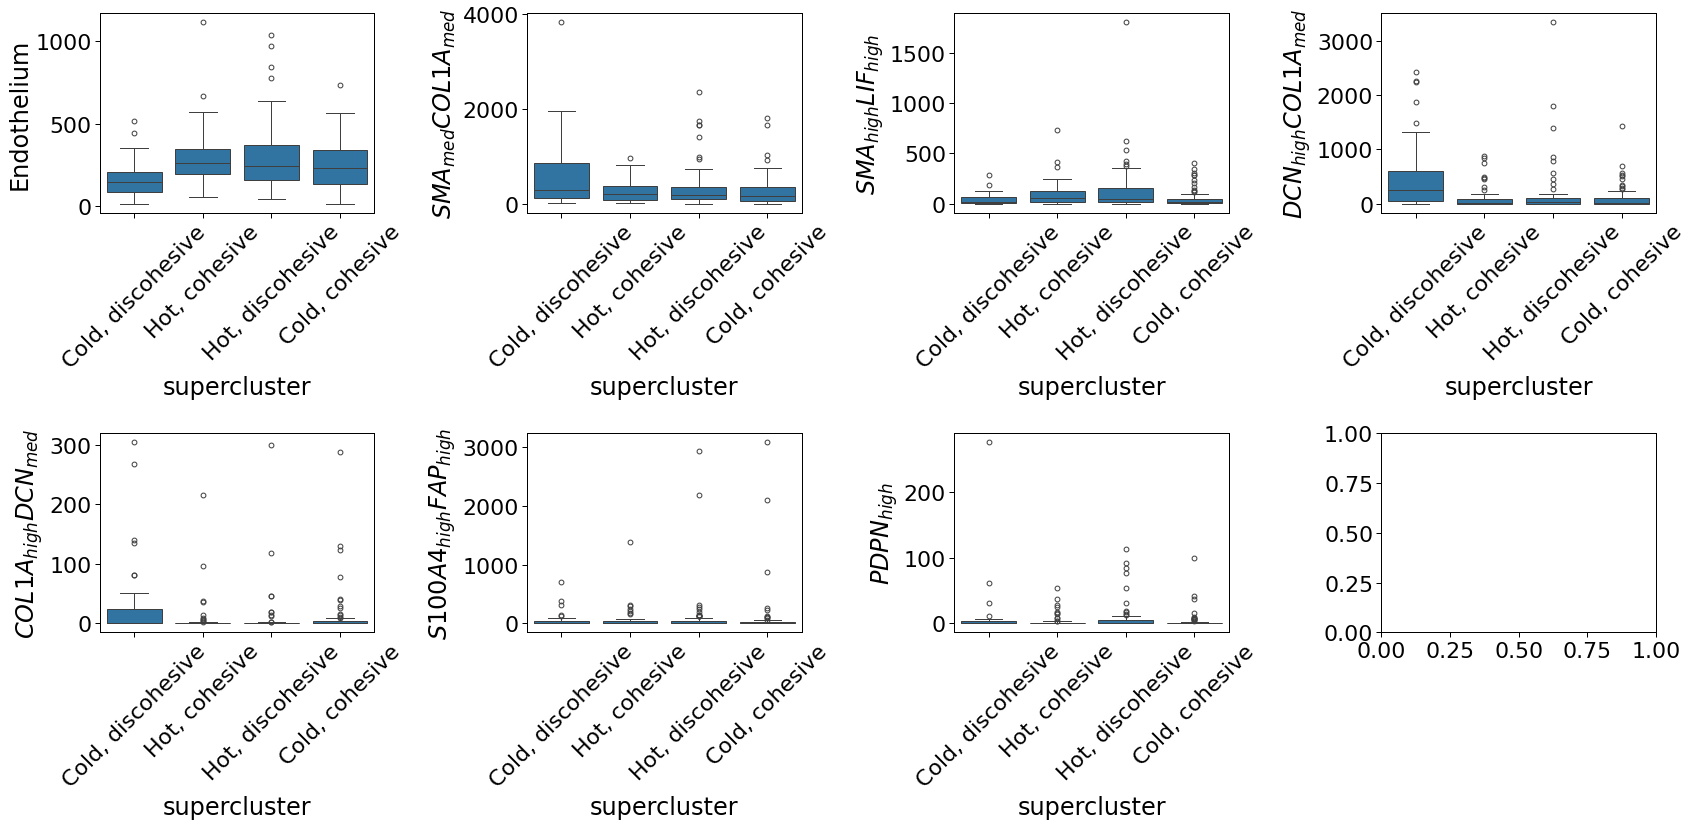

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24,12))
axs = axs.flatten()

i=0

for _, v in fibroblast_phenotype_dict.items():
    if v == 'Unclassifiable':
        continue
    sns.boxplot(core_cell_densities_noID, x = 'supercluster', y = v, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
    i += 1

plt.tight_layout()
plt.show()

In [24]:
phenotypes_list = list()

for _, v in fibroblast_phenotype_dict.items():
    if v != 'Unclassifiable':
        phenotypes_list.append(v)

In [25]:
log_densities = core_cell_densities_noID.copy(deep=True)
log_densities[phenotypes_list] = core_cell_densities_noID[phenotypes_list].apply(lambda row: np.log(row + 1))
log_densities

,Endothelium,$SMA_{med}COL1A_{med}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$,$SMA_{high}LIF_{high}$,core_ID,supercluster
0,5.098905,6.565427,2.070585,1.913173,5.738235,0.767749,0.000000,12-02-A,"Cold, discohesive"
1,4.781749,4.970167,0.730236,0.000000,3.160696,0.000000,5.298221,12-02-B,"Hot, cohesive"
2,4.852374,4.392673,0.000000,0.000000,2.660915,0.000000,2.475655,12-02-C,"Hot, cohesive"
3,6.264672,6.901797,0.000000,0.000000,7.987788,0.000000,3.594612,12-02-D,"Hot, discohesive"
6,5.365892,5.272618,0.000000,0.000000,5.213392,0.000000,5.163347,12-03-B,"Hot, cohesive"
...,...,...,...,...,...,...,...,...,...
253,6.235304,5.363686,3.755208,0.000000,1.567538,0.000000,2.255322,22-14-G,"Cold, cohesive"
254,6.029096,3.490559,0.000000,0.000000,2.656882,0.000000,2.592889,22-14-H,"Hot, discohesive"
255,4.959089,5.683690,1.800435,0.000000,5.350292,0.000000,1.800435,22-15-A,"Hot, cohesive"
256,5.267180,2.535171,0.770968,0.000000,3.729663,0.000000,0.000000,22-15-I,"Hot, cohesive"


In [26]:
from itertools import combinations

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


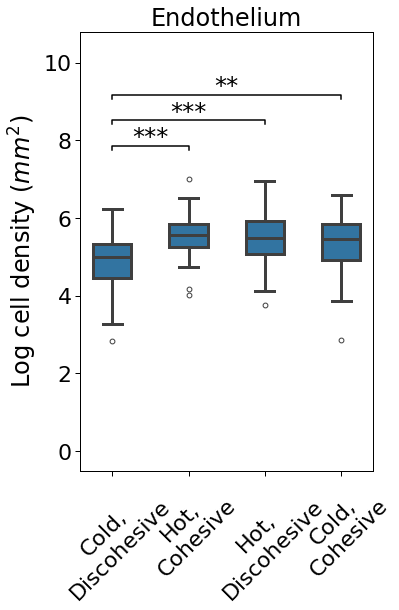

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


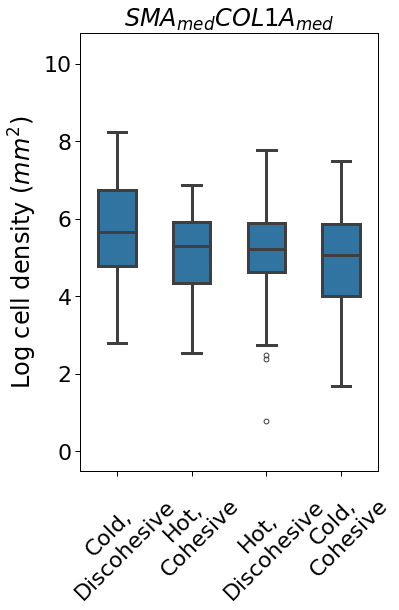

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


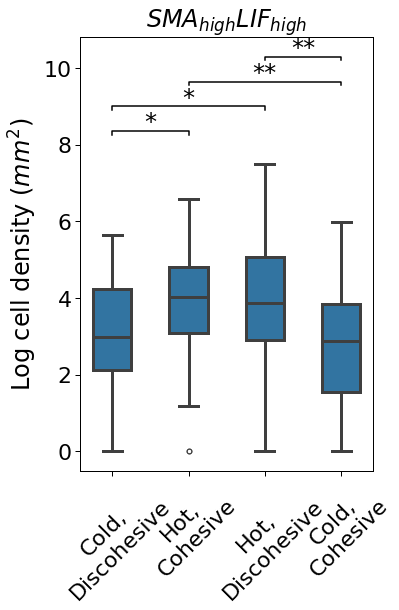

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


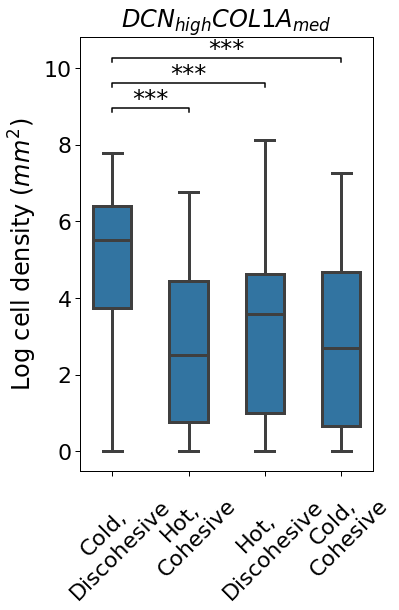

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


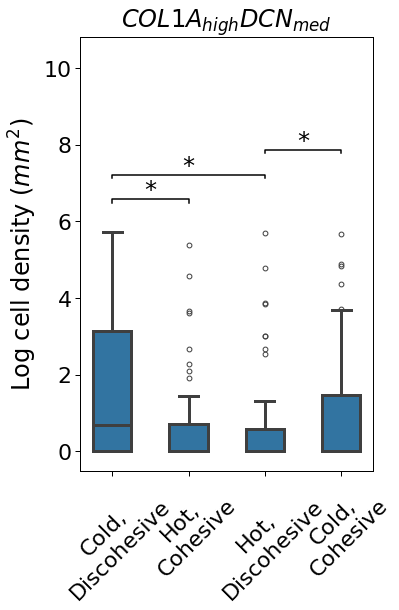

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


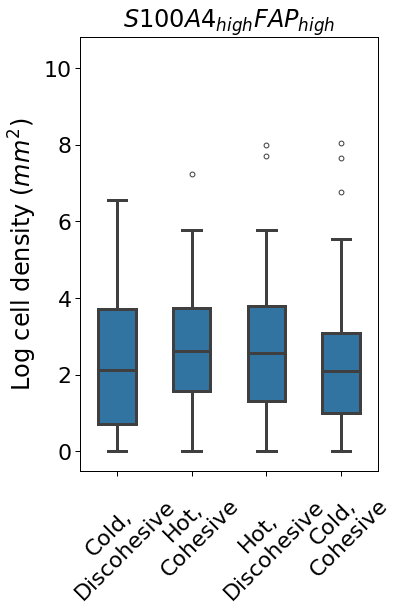

/tmp/ipykernel_3933243/1422185407.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3933243/1422185407.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])


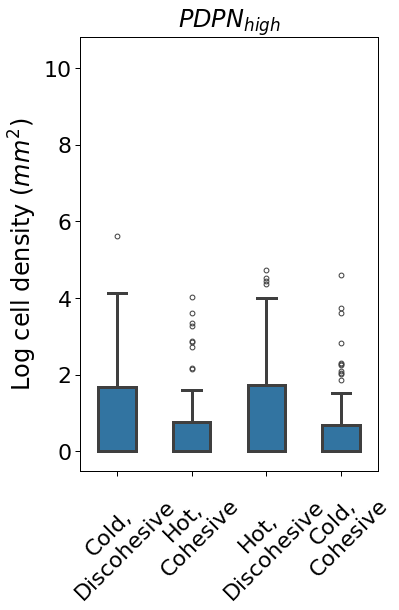

In [27]:
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24,16), sharey=True)
# sns.set_context("paper", font_scale=2.0)

# fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(42,8), sharey=True)
# axs = axs.flatten()


i=0

for _, v in fibroblast_phenotype_dict.items():
    if v == 'Unclassifiable':
        continue
    fig, ax = plt.subplots(figsize=(6,9))
    sns.boxplot(log_densities, x = 'supercluster', y = v, linewidth=3, width=0.5, ax=ax)

    # sns.violinplot(data=log_densities, x='supercluster', y=v, linewidth=2, linecolor='black', color='grey', alpha=0.8, ax=ax)
    # sns.boxplot(data = log_densities, x = 'supercluster', y = v, width=.3, linewidth=2, linecolor="black", color='white', ax=ax)

    density_values = list()
    for sc in log_densities['supercluster'].unique():
        density_values.append(log_densities[log_densities['supercluster'] == sc][v].values)
    stat, p_val = kruskal(*density_values)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel(r'Log cell density ($mm^2$)')
    # ax.set_title(f'Kruskal p = {p_val:.2f}')
    ax.set_title(f'{v}')
    ax.set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])
    ax.set_xlabel(None)
    ax.set_ylim([-0.5, 10.8])

    sc = log_densities['supercluster'].unique()
    pairwise_results = list()

    for group1, group2 in combinations(sc, 2):
        values1 = log_densities[log_densities['supercluster'] == group1][v].values
        values2 = log_densities[log_densities['supercluster'] == group2][v].values
        stat, p = mannwhitneyu(values1, values2, alternative='two-sided', nan_policy='omit')
        pairwise_results.append((group1, group2, p))

    pairwise_df = pd.DataFrame(pairwise_results, columns=['group1', 'group2', 'p_val'])
    pairwise_df['p_adj'] = false_discovery_control(pairwise_df['p_val'].values, method='bh')

    # Plot the pairwise data
    y_max = log_densities[v].max() + 0.5
    y_offset = 0.25  # Space between the boxes and annotation lines
    y_step = 0.65    # Space between annotation lines for different pairs

    for _, row in pairwise_df.iterrows():
        if row['p_adj'] < 0.05:  # Only annotate significant pairs
            x1, x2 = sc.tolist().index(row['group1']), sc.tolist().index(row['group2'])
            y = y_max + y_offset
            y_max += y_step  # Increment for the next pair
            
            # Draw the annotation line
            ax.plot([x1, x1, x2, x2], [y, y + 0.1, y + 0.1, y], lw=1.5, color='black')
            
            # Add significance level as text
            if row['p_adj'] < 0.001:
                significance = "***"
            elif row['p_adj'] < 0.01:
                significance = "**"
            elif row['p_adj'] < 0.05:
                significance = "*"
            else:
                significance = "ns"
            
            ax.text((x1 + x2) * 0.5, y + 0.01, significance, ha='center', va='bottom', color='black')
    plt.tight_layout()
    plt.savefig(f'/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/cell_log_density_{v}.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    i += 1

# plt.tight_layout()
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/cell_densities_log_supercluster_boxplots.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.show()

## Enrichment tests - heatmaps 

In [28]:
from scipy.stats import mannwhitneyu, false_discovery_control

def enrichment_test_by_phenotype(data, phenotype_cols, meta_col, p_th=0.05):
    results = list()
    for group in data[meta_col].unique():
        for phenotype in phenotype_cols:
            positive_group = data[data[meta_col] == group][phenotype].values
            negative_group = data[data[meta_col] != group][phenotype].values
            statistic, p_value = mannwhitneyu(positive_group, negative_group, alternative='two-sided')
            relative_change = (np.median(positive_group) - np.median(negative_group)) / (abs(np.median(negative_group)) + 0.001)

            results.append({
                'Supercluster':group,
                'marker':phenotype,
                'relative change':relative_change,
                'statistic':statistic,
                'p_val': p_value
            })

    results = pd.DataFrame(results)
    results['p_adj'] = false_discovery_control(results['p_val'], method='bh')
    change_data = results.pivot(index='Supercluster', columns='marker', values='relative change')
    pval_data = results.pivot(index='Supercluster', columns='marker', values='p_adj')

    significant_mask = pval_data < p_th
    annot_text = change_data.applymap('{:.2f}'.format)
    annot_text = annot_text.mask(significant_mask, '*')
    annot_text = annot_text.mask(~significant_mask, ' ')

    return change_data, annot_text
    

change_data, annot_text = enrichment_test_by_phenotype(data=core_cell_densities, 
                                                         phenotype_cols=[col for col in core_cell_densities if 'kmeans' in col], 
                                                         meta_col='supercluster')
change_data.columns = [int(col.split("_")[1]) for col in core_cell_densities.columns if 'kmeans' in col]
change_data.columns = change_data.columns.map(fibroblast_phenotype_dict)

change_data

,Endothelium,$SMA_{med}COL1A_{med}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$,$SMA_{high}LIF_{high}$
Supercluster,,,,,,,
"Cold, cohesive",0.006846,-0.186614,-0.661160,-0.506619,0.000000,-0.366285,0.0
"Cold, discohesive",-0.404293,0.691984,-0.509628,10.505241,974.977875,-0.362957,0.0
"Hot, cohesive",0.252758,0.075771,1.233781,-0.733611,0.000000,0.319820,0.0
"Hot, discohesive",0.141543,-0.059912,0.654491,0.150348,0.000000,0.434163,0.0


In [29]:
change_data, annot_text = enrichment_test_by_phenotype(data=core_cell_densities_noID, 
                                                         phenotype_cols=phenotypes_list, 
                                                         meta_col='supercluster')
# change_data.columns = [int(col.split("_")[1]) for col in core_cell_densities.columns if 'kmeans' in col]
# change_data.columns = change_data.columns.map(fibroblast_phenotype_dict)

change_data

marker,$COL1A_{high}DCN_{med}$,$DCN_{high}COL1A_{med}$,$PDPN_{high}$,$S100A4_{high}FAP_{high}$,$SMA_{high}LIF_{high}$,$SMA_{med}COL1A_{med}$,Endothelium
Supercluster,,,,,,,
"Cold, cohesive",0.00000,-0.598723,0.0,-0.399447,-0.636366,-0.199593,0.070355
"Cold, discohesive",991.94612,10.979664,0.0,-0.253456,-0.493868,0.535180,-0.400071
"Hot, cohesive",0.00000,-0.680141,0.0,0.491920,0.965436,0.052412,0.231462
"Hot, discohesive",0.00000,0.353528,0.0,0.343431,0.791796,-0.053336,0.137461


### Relative change (raw density)

Text(0.5, 1.0, 'Relative change (KMeans = 9)')

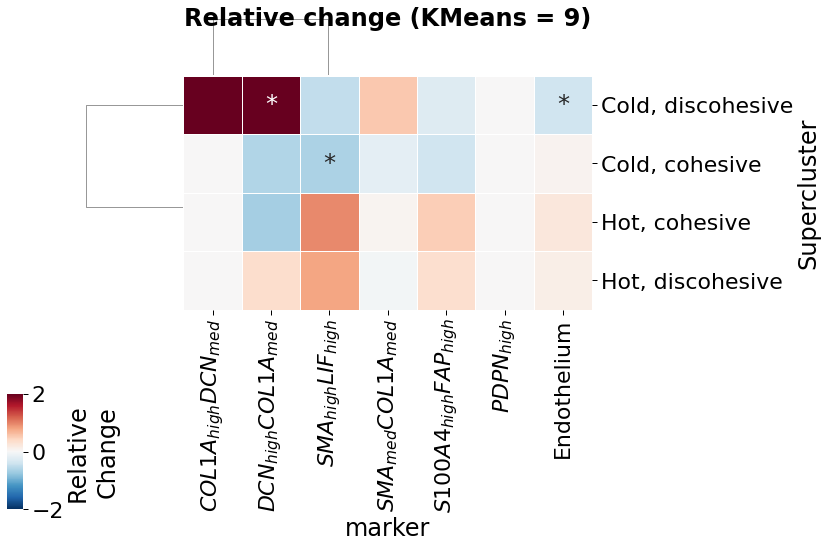

In [30]:
g = sns.clustermap(data=change_data,
               annot=annot_text,
               fmt='',
               cmap='RdBu_r',
            #    z_score=1, 
               vmin=-2, vmax=2,
               figsize=(11,8),
               cbar_kws={'label': 'Relative \nChange'},
               linewidth=.5,
               # dendrogram_ratio=(.1, .1),
               cbar_pos=(-.06, .1, .02, .2))

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
g.ax_heatmap.set_title('Relative change (KMeans = 9)', pad=50, fontdict={'fontweight':'bold'})


### Relative change (log density)

Text(0.5, 1.0, 'Relative change (KMeans = 9)')

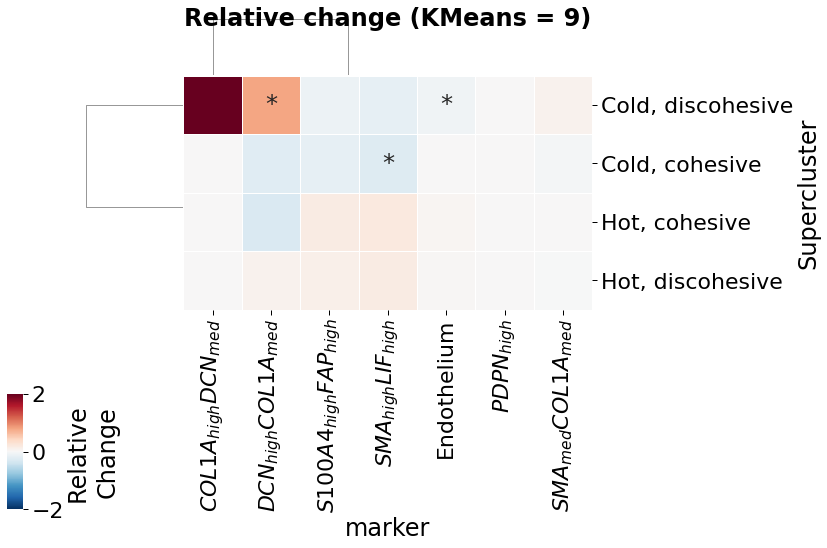

In [31]:
change_data, annot_text = enrichment_test_by_phenotype(data=log_densities, 
                                                         phenotype_cols=phenotypes_list, 
                                                         meta_col='supercluster')

# change_data.columns = [int(col.split("_")[1]) for col in log_densities.columns if 'kmeans' in col]
# change_data.columns = change_data.columns.map(fibroblast_phenotype_dict)

g = sns.clustermap(data=change_data,
               annot=annot_text,
               fmt='',
               cmap='RdBu_r',
            #    z_score=1, 
               vmin=-2, vmax=2,
               figsize=(11,8),
               cbar_kws={'label': 'Relative \nChange'},
               linewidth=.5,
               # dendrogram_ratio=(.1, .1),
               cbar_pos=(-.06, .1, .02, .2))

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
g.ax_heatmap.set_title('Relative change (KMeans = 9)', pad=50, fontdict={'fontweight':'bold'})

## Supercluster average/median densities

### Raw densities

In [32]:
# Convert densities to super/cluster averages

clusters_list = list()

for cluster in core_cell_densities['supercluster'].unique():
    # cluster = cluster.split(" ")[1]
    cluster_subset = core_cell_densities[core_cell_densities['supercluster'] == cluster]
    markers_list = list()
    markers_list.append(cluster)
    for col in [col for col in core_cell_densities if 'kmeans' in col]:
        cluster_mean = np.mean(cluster_subset[col].values)
        markers_list.append(cluster_mean)
    clusters_list.append(markers_list)

density_per_supercluster = pd.DataFrame(clusters_list, columns=['Supercluster']+[col for col in core_cell_densities if 'kmeans' in col]).set_index('Supercluster').sort_index()
density_per_supercluster.columns = [int(col.split("_")[1]) for col in core_cell_densities.columns if 'kmeans' in col]
density_per_supercluster.columns = density_per_supercluster.columns.map(fibroblast_phenotype_dict)
density_per_supercluster.index = ['Cold, Discohesive', 'Cold, Cohesive', 'Hot, Cohesive', 'Hot, Discohesive']
density_per_supercluster

,Endothelium,$SMA_{med}COL1A_{med}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$,$SMA_{high}LIF_{high}$
"Cold, Discohesive",251.961266,272.131673,100.916770,11.339292,100.730716,3.247690,48.815973
"Cold, Cohesive",157.298198,625.344623,525.036391,32.300486,116.349216,12.235754,41.450837
"Hot, Cohesive",298.611533,246.702290,110.068813,7.706744,63.517982,4.120364,91.557186
"Hot, Discohesive",300.639805,331.871863,165.107075,7.926907,225.206035,9.292761,120.144436


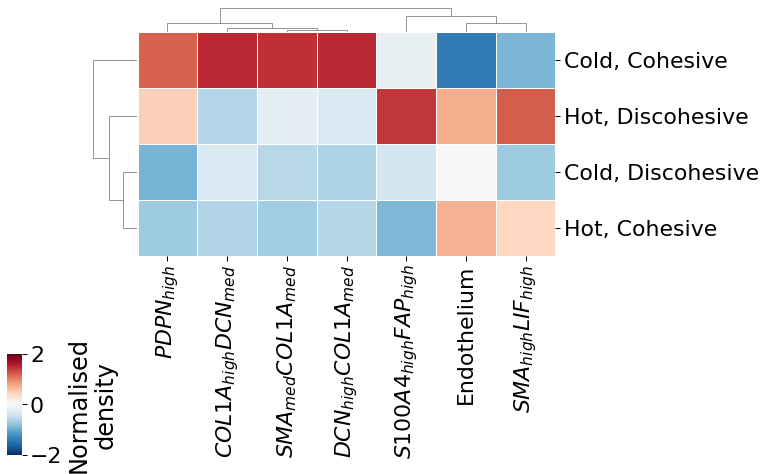

In [33]:
g = sns.clustermap(data=density_per_supercluster,
               cmap='RdBu_r',
               z_score=1, 
               vmin=-2, vmax=2,
               figsize=(10,7),
               cbar_kws={'label': 'Normalised\ndensity'},
               linewidth=.5,
               dendrogram_ratio=(.1, .1),
               cbar_pos=(-.08, .06, .02, .2))

# plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=30)

### Log densities

In [34]:
# Convert densities to super/cluster averages

clusters_list = list()

for cluster in log_densities['supercluster'].unique():
    # cluster = cluster.split(" ")[1]
    cluster_subset = log_densities[log_densities['supercluster'] == cluster]
    markers_list = list()
    markers_list.append(cluster)
    for col in phenotypes_list:
        cluster_mean = np.mean(cluster_subset[col].values)
        markers_list.append(cluster_mean)
    clusters_list.append(markers_list)

density_per_supercluster = pd.DataFrame(clusters_list, columns=['Supercluster']+phenotypes_list).set_index('Supercluster').sort_index()
# density_per_supercluster.columns = [int(col.split("_")[1]) for col in log_densities.columns if 'kmeans' in col]
# density_per_supercluster.columns = density_per_supercluster.columns.map(fibroblast_phenotype_dict)
density_per_supercluster

,Endothelium,$SMA_{med}COL1A_{med}$,$SMA_{high}LIF_{high}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$
Supercluster,,,,,,,
"Cold, cohesive",5.346606,4.958646,2.794801,2.769402,0.970966,2.226546,0.544210
"Cold, discohesive",4.809447,5.665348,3.095270,4.968808,1.580578,2.459668,0.931871
"Hot, cohesive",5.543136,5.090134,3.805564,2.708840,0.647323,2.790119,0.644579
"Hot, discohesive",5.506839,5.197669,3.831996,3.154404,0.543678,2.663810,0.923103


In [35]:
core_cell_densities

,core_ID,kmeans_0,kmeans_1,kmeans_4,kmeans_5,kmeans_6,kmeans_8,kmeans_2,cluster,supercluster
0,12-02-A,162.842373,709.115015,6.929463,5.774552,309.516000,1.154910,0.000000,HPC 27,"Cold, discohesive"
1,12-02-B,118.312837,143.050976,1.075571,0.000000,22.586996,0.000000,198.980681,HPC 0,"Hot, cohesive"
2,12-02-C,127.044033,79.856249,0.000000,0.000000,13.309375,0.000000,10.889489,HPC 67,"Hot, cohesive"
3,12-02-D,524.669259,993.059116,0.000000,0.000000,2943.775789,0.000000,35.401559,HPC 10,"Hot, discohesive"
5,12-02-J,122.065147,140.374919,63.066993,0.000000,2.034419,0.000000,26.447449,HPC 64,"Cold, discohesive"
...,...,...,...,...,...,...,...,...,...,...
253,22-14-G,509.455765,212.510412,41.743117,0.000000,3.794829,0.000000,8.538365,HPC 68,"Cold, cohesive"
254,22-14-H,414.339284,31.804295,0.000000,0.000000,13.251789,0.000000,12.368337,HPC 28,"Hot, discohesive"
255,22-15-A,141.463904,293.032372,5.052282,0.000000,209.669715,0.000000,5.052282,HPC 50,"Hot, cohesive"
256,22-15-I,192.868512,11.618585,1.161859,0.000000,40.665048,0.000000,0.000000,HPC 50,"Hot, cohesive"


In [41]:
def enrichment_test_by_phenotype(data, phenotype_cols, meta_col, p_th=0.05):
    results = list()
    overall_avg = data.mean(numeric_only=True, axis=0)
    for group in data[meta_col].unique():
        for phenotype in phenotype_cols:
            positive_group = data[data[meta_col] == group][phenotype].values
            negative_group = data[data[meta_col] != group][phenotype].values
            statistic, p_value = mannwhitneyu(positive_group, negative_group, alternative='two-sided')
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            log_fc = np.log2((np.mean(positive_group) + 1e-9) / (overall_avg.loc[phenotype] + 1e-9))


            results.append({
                'Supercluster':group,
                'marker':phenotype,
                'l2fc':log_fc,
                'statistic':statistic,
                'p_val': p_value
            })

    results = pd.DataFrame(results)
    results['p_adj'] = false_discovery_control(results['p_val'], method='bh')
    change_data = results.pivot(index='Supercluster', columns='marker', values='l2fc')
    pval_data = results.pivot(index='Supercluster', columns='marker', values='p_adj')

    significant_mask = pval_data < p_th
    annot_text = change_data.applymap('{:.2f}'.format)
    annot_text = annot_text.mask(significant_mask, '*')
    annot_text = annot_text.mask(~significant_mask, ' ')

    return change_data, annot_text
    

change_data, annot_text = enrichment_test_by_phenotype(data=core_cell_densities[~core_cell_densities['core_ID'].isin(all_cores_to_exclude)], 
                                                         phenotype_cols=[col for col in core_cell_densities.columns if col not in ['core_ID', 'cluster', 'supercluster']], 
                                                         meta_col='supercluster')
change_data.columns = [int(col.split("_")[1]) for col in change_data.columns if 'kmeans' in col]
change_data.columns = change_data.columns.map(fibroblast_phenotype_dict)
# change_data.index = ['Cold, cohesive', 'Cold, discohsive', 'Hot, cohesive', 'Hot, discohesive']
change_data.columns.name = None
change_data

,Endothelium,$SMA_{med}COL1A_{med}$,$SMA_{high}LIF_{high}$,$DCN_{high}COL1A_{med}$,$COL1A_{high}DCN_{med}$,$S100A4_{high}FAP_{high}$,$PDPN_{high}$
Supercluster,,,,,,,
"Cold, cohesive",-0.051734,-0.303438,-0.694579,-0.839889,-0.200007,0.130406,-0.892381
"Cold, discohesive",-0.720300,0.822848,-0.877404,1.529126,1.431742,-0.482534,1.000225
"Hot, cohesive",0.160239,-0.410158,0.181210,-0.822207,-0.683016,-0.454218,-0.634750
"Hot, discohesive",0.177394,0.059926,0.612959,-0.081529,-0.632800,0.304634,0.397878


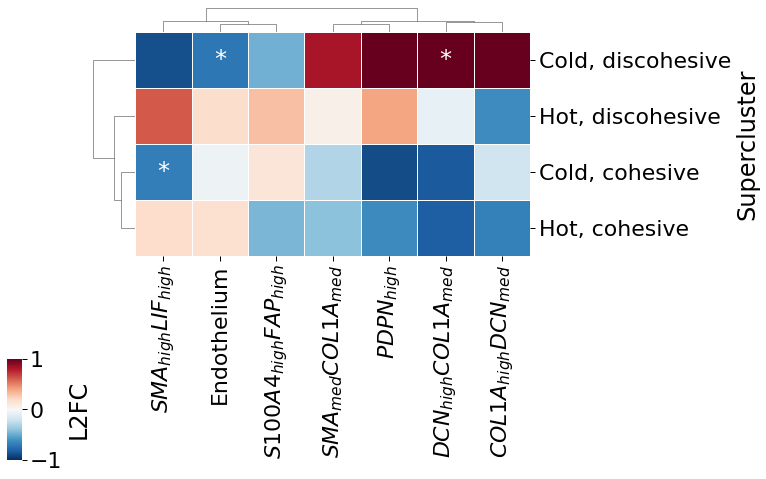

In [42]:
g = sns.clustermap(data=change_data,
               cmap='RdBu_r',
            #    z_score=1, 
               vmin=-1, vmax=1,
               annot=annot_text,
               fmt='',
               annot_kws={'fontsize':24},
               figsize=(10,7),
               cbar_kws={'label': 'L2FC'},
               linewidth=.5,
               dendrogram_ratio=(.1, .1),
               cbar_pos=(-.08, .05, .02, .2))

plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/cell_density_heatmap_supercluster_average_zscore_one_v_rest_stats_L2FC.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=30)

In [33]:
g.ax_heatmap.xaxis.get_label()

Text(0.5, 78.01097210681039, '')

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-e

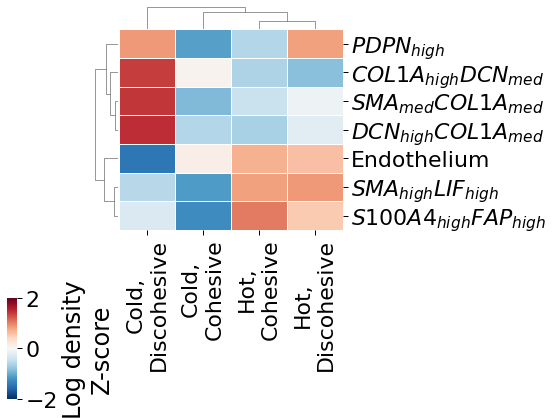

In [43]:
g = sns.clustermap(data=density_per_supercluster.T,
               cmap='RdBu_r',
               z_score=0, 
               vmin=-2, vmax=2,
               figsize=(7,7),
               cbar_kws={'label': 'Log density\nZ-score'},
               linewidth=.5,
               dendrogram_ratio=(.1, .1),
               cbar_pos=(-.12, .17, .02, .2))

plt.setp(g.ax_heatmap.xaxis.set_ticklabels(['Cold,\nDiscohesive', 'Cold,\nCohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive']), rotation=90)
plt.setp(g.ax_heatmap.xaxis.set_label_text(None))
# plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=30)
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/cell_density_heatmap_supercluster_average_zscore.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# axs[i].set_xticklabels(['Cold,\nDiscohesive', 'Hot,\nCohesive', 'Hot,\nDiscohesive', 'Cold,\nCohesive'])
